In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
import csv
import math

## param

In [294]:
x_pixel = 8
epochs = 1
out_pixels = 64

with open('weights.csv', 'wb') as myfile:
  x = np.random.uniform(0,0.1,size = [65,64])
  np.savetxt( "weights.csv", x, delimiter="," )


def read_img():

	img = cv2.imread("2.png", 0)
	img2 = cv2.imread("2.png",0)

	img = np.ndarray.flatten(img)
	return img

def read_dataset():
	df = pd.read_csv("weights.csv" )
	df = df.values
	return df

def recon_weights(W):
	
	temp = W[i]
	recon = np.reshape(temp,(x_pixel,x_pixel))*255
	cv2.imwrite("reconstract" + ".png",recon)
	

x = read_img()
normalized = (x-np.min(x))/float(np.max(x)-np.min(x))*50


## neuron class

In [295]:
class LIFneuronConfig():
    def __init__(self,):
        self.R = 10 # resistance (k-Ohm)
        self.C = 10 # capacitance (u-F)

        self.v_thresh = 0.05
        self.v_spike = 1
        self.v_base = 0
        
        self.tau_m = self.R*self.C # time constant (msec)
        self.refracTime = 0.2 # refractory time (msec)
        self.initRefrac = 0

        self.noise_amp = 0

        self.isPlot = 1


class LIF():
    def __init__(self):
        LIFneuronConfig.__init__(self,)
        self.num=0 #numbers of spikes
        self.isNoise = 0
        self.vprev = self.v_base

    def noiseTerm(self,dt):
        sigma = self.noise_amp

        y = np.random.normal(0,1,1)
        return sigma*math.sqrt(dt)*y

    def generateSpiking(self, I, t, dt):

        v = self.v_base
        if t >= self.initRefrac:
            noise = 0
            if self.isNoise:
                noise = self.noiseTerm(dt)

            v = self.vprev + (-self.vprev + I*self.R) / self.tau_m * dt +noise
            if v >= self.v_thresh:
                self.num+=1
                v += self.v_spike
                self.initRefrac = t + self.refracTime
        self.vprev = v 
        return v
    
    def check(self):
      if self.vprev >= self.v_thresh:
        return 1
      else:
        return 0




class LIF_simple():
  def __init__(self):
    LIFneuronConfig.__init__(self,)
    self.num=0 
    self.vprev = self.v_base

  def generateSpiking(self,I,t,dt):
    v = self.v_base

    if t >= self.initRefrac:
      
      v = self.vprev + (-self.vprev + I*self.R) / self.tau_m * dt
        
      if v >= self.v_thresh:
        self.num+=1
        v += self.v_spike
        self.initRefrac = t + self.refracTime

    self.vprev = v 
    return v


def PlotNeuron(model, time, dt, I):
    neuron = model
    v = np.zeros_like(time)

    for i, t in enumerate(time):
        v[i] = neuron.generateSpiking(I[i], t, dt)

    if model.isPlot:
        plt.plot(t_span,v, label = 'V')
        plt.vlines(t_span, [0], I, label = 'input spikes',linewidth=0.5)
        plt.title('Neuron Model LIF')
        plt.ylabel('Membrane Potential (V) and input current(I)')
        plt.xlabel('Time (msec)')
        plt.grid()
        plt.legend(loc="upper right")
        plt.show()
    return v


def count_spikes(array):
  count = 0
  maximum = max(array)
  for i in array:
    if i == 1 :
      count +=1
  return count



### time range

In [296]:
#time series
T = 100 #ms
dt = 0.1
time = np.arange(0,T+dt,dt)

#Synapses weight
W = read_dataset()

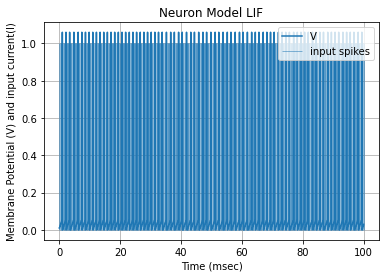

79  spikes neuron 


501

In [297]:
t_span = np.arange(0, T+dt, dt)
I = [1 if i%2==0  else 0 for i in range(len(time))]
neuron = LIF_simple()
PlotNeuron(neuron, time, dt, I);
print(neuron.num, ' spikes neuron ')
count_spikes(I)

# Encoding input images to input spikes

In [298]:
def Poisson_generator(time,dt,rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    rate            : noise amplitute [Hz]
    n               : number of Poisson trains
    myseed          : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  range_t = np.arange(0, time+dt, dt)  # Vector of discretized time points [ms]
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 100))

  return poisson_train

# Neural network

In [441]:
# input neuron spikes
#x = np.random.rand(8,8)*255
#x = x.flatten()

#time series
T = 100 #ms
dt = 0.1
time = np.arange(0,T+dt,dt)

#Synapses weight
W = read_dataset()


in_spikes = np.empty(shape=(x_pixel**2,len(time)))
for i in range(x_pixel*x_pixel):
  in_spikes[i]=Poisson_generator(T,dt,x[i],1)

out_spikes = np.zeros(shape=(out_pixels,len(time)))

out_neurons = []
# creating the output layer of neurons
for i in range(out_pixels):
	a = LIF_simple()
	out_neurons.append(a)


def update(w, dt):
  if dt > 0:
    w += 0.1* np.exp(-dt /100)
  else:
    w -= 0.1* np.exp(dt /100)
  
  if w>1 and w<0:
    w=0
  return w

In [442]:
update(W[1][7],-1)

-0.04307402224980617

In [435]:
W[1][7]

0.05593096112511064

In [318]:
last_index=0


membrane_pot = []
I = np.zeros(shape=(x_pixel**2,))
for t in range(len(time)):

  
  for j,neu in enumerate(out_neurons): # j - output neuron
    for i in range(x_pixel**2): # i - input neuron
      I[j] = 0
      I[j] += np.dot(W[i][j],in_spikes[i][t])
      
      if t >= neu.initRefrac:
      
        v = neu.vprev + (-neu.vprev + I[j]*neu.R) / neu.tau_m * dt
        
        if v >= neu.v_thresh:
          neu.num+=1
          out_spikes[j][t]= 1
          v += neu.v_spike
          neu.initRefrac = t + neu.refracTime
          v = neu.v_base
          
        neu.vprev = v

    for i in range(x_pixel**2):   
      for t1 in range(-1,-50,-1):
        if 0<= t+t1<len(time):
          if in_spikes[i][t+t1]==1:
            W[i][j] = update(W[i][j],t1)
      for t1 in range(1,50,1):
        if 0<= t+t1<len(time):
          if in_spikes[i][t+t1]==1:
            W[i][j] = update(W[i][j],t1)



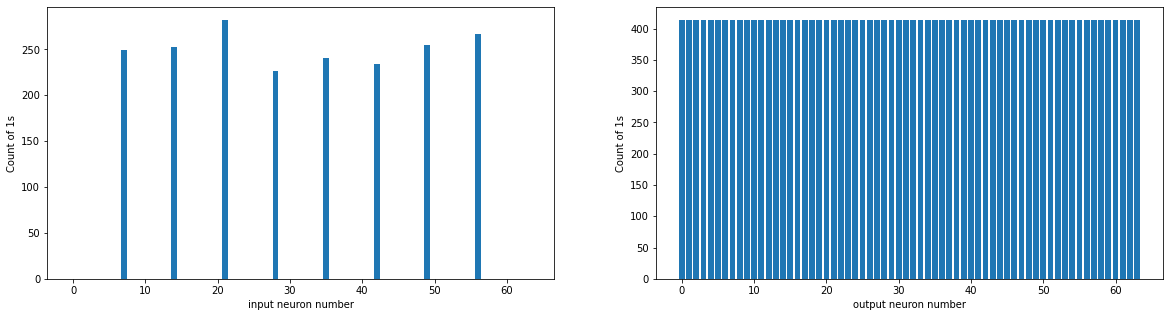

In [319]:
in_counts = np.count_nonzero(in_spikes,axis = 1)
out_counts = np.count_nonzero(out_spikes, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.bar(range(in_spikes.shape[0]), in_counts)
ax1.set_xlabel("input neuron number")
ax1.set_ylabel("Count of 1s")

ax2.bar(range(out_spikes.shape[0]), out_counts)
ax2.set_xlabel("output neuron number")
ax2.set_ylabel("Count of 1s")

plt.show()

# Testing

In [338]:
W = read_dataset()

In [339]:
W[1][1] = update(W[1][1],rl(30))


In [341]:
update(W[7][7],rl(30))

0.09152368116911488